### Objectif de la manip:
Mes données de mesures sont sur un espace borné, de dimension inférieure à ma simulation, pour cettee raison je dois compléter mes données expérimentales par un modèle à grande distance: d>5cm latéralement.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:

# Charger le fichier CSV comme avant
data = np.loadtxt('mesureB_n.csv', delimiter=',', dtype=float)  # skiprows=1 pour ignorer l'en-tête si présent

#récupérer la ligne désirée en partant du bas
def fetchline(line_num):
    return np.flip(data[-line_num, :])
def fetchdist(offset=0.5):
    return np.arange(-5, 5.5, 0.5) - offset
line_num = 2
vals = fetchline(line_num)
offset = 0.
dist = fetchdist(offset)

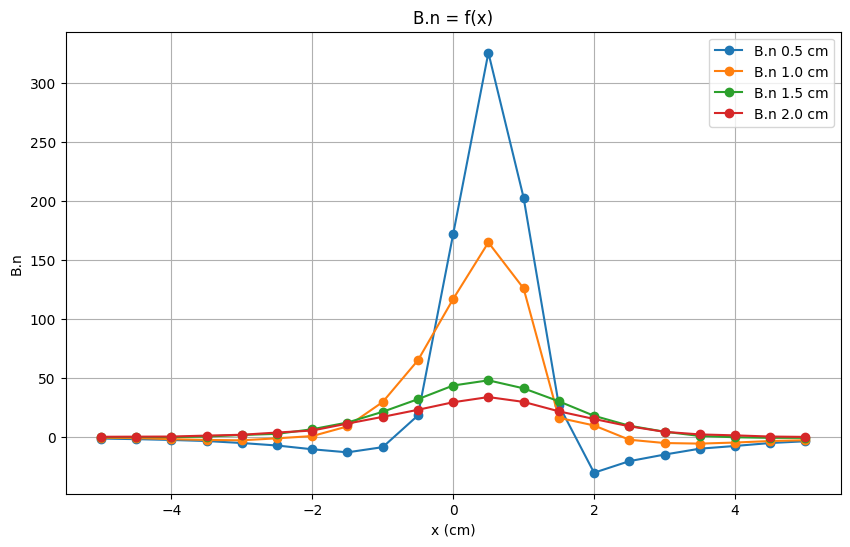

In [60]:


plt.figure(figsize=(10, 6))
N=5
for i in range(1,N):
    plt.plot(dist, fetchline(i), marker='o', linestyle='-', label=f'B.n {i*0.5} cm')
plt.xlabel('x (cm)')
plt.ylabel('B.n')
plt.title('B.n = f(x)')
plt.legend()
plt.grid(True)
plt.show()

deux problemes: j'ai mal identifié le centre de mon capteur horizontalement, aussi on a un problème de symétrie -> il peut etre du au fait que le champ magnetique affecte la sonde differemetn d'un coté et de l'autre  et donc une erreur de manipulation.
J'aurais tendance a faire plus confiance a la mesure pour d\<0.5

Mais plsu approximativement on décale l'origine pour se placer sur l'axe de symétrie et on considère les mesures symétriques comme deux mesures expérimentales de la meme valeur de champ.
Et on moyenne pour obtenir un champ symétrique comme attendu.

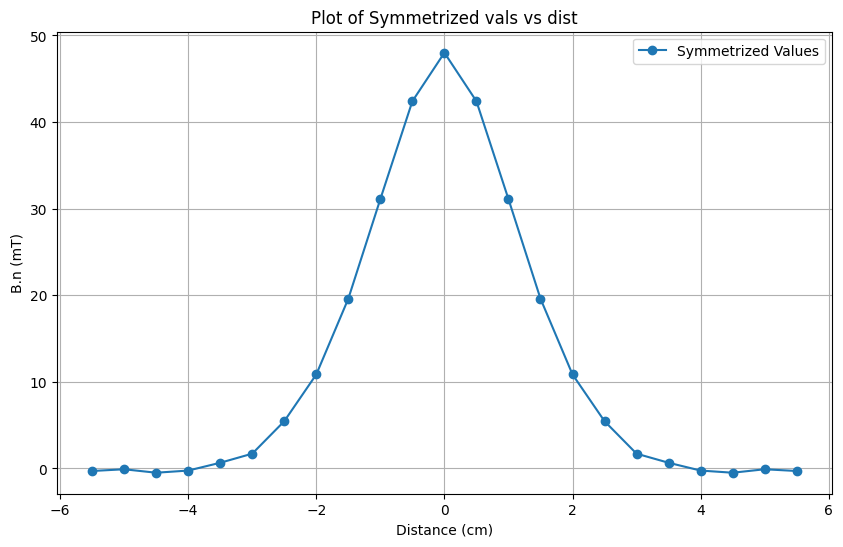

In [5]:
def moy_none(a,b):
    if a is None:
        return b
    if b is None:
        return a
    return (a+b)/2

def moy_sym(L:list, offset=0)->list:
    M = []
    n = len(L)
    for i in range(n+2*offset):
        index1 = i
        index2 = n+2*offset-i-1
        valeur1 = L[index1] if index1<n else None
        valeur2 = L[index2] if index2<n else None
        valeur = moy_none(valeur1, valeur2)
        M.append(valeur)
    return np.array(M)

def dist_sym(n,offset):
    return np.arange((-n//2-offset)*0.5+0.5, (n//2+offset)*0.5+0.5, 0.5)


vals_trunc = fetchline(3)
dist_trunc = dist_sym(len(vals_trunc),1)
vals_trunc = moy_sym(vals_trunc, offset=1)

plt.figure(figsize=(10, 6))
plt.plot(dist_trunc, vals_trunc, marker='o', linestyle='-', label='Symmetrized Values')
plt.xlabel('Distance (cm)')
plt.ylabel('B.n (mT)')
plt.title('Plot of Symmetrized vals vs dist')
plt.legend()
plt.grid(True)
plt.show()

On a donc un champ latéral réaliste par symétrie et moyennage, on passe donc à la simulation de fem induite, mes valeurs expérimentales étant bornées sur un intervalle de l'ordre de 10cm il faut les prolonger à l'extérieur.

Ici je fais le choix d'une constante de façon a garder la continuité du champ sur les bords et considérer la variation du champ et donc l'influence sur la fem nulle à partir de 5cm sur le coté.
On pourrait modéliser plus rigoureusement mais vu l'arrivée de l'aimant suivant le champ de clui ci prédomine largement et on peut négliger l'effet a gde distance.

In [6]:
from scipy.interpolate import interp1d

def get_field_at_distance(offsetx, dist_array, vals_array):
    # Vérifie si l'offset est dans les limites
    # Si on est en dehors, prendre la valeur constante la plus proche
    # c'est légitime du momt qu'un autre aimant vient apres et que son champ prédomine devant les valeurs réelles attendues, d'ordre inférieur à cette constante.
    if offsetx < dist_array[0]:
        return vals_array[0]  # Valeur du bord gauche
    elif offsetx > dist_array[-1]:
        return vals_array[-1]  # Valeur du bord droit
    else:
        # Interpolation linéaire dans les bornes de mes mesures
        interpolator = interp1d(dist_array, vals_array, kind='linear', fill_value="extrapolate")
        return interpolator(offsetx)

# Exemple d'utilisation
offset_to_check = 2.75
field_value = get_field_at_distance(offset_to_check, dist_trunc, vals_trunc)
print(f"Valeur du champ à la distance {offset_to_check} : {field_value}")

Valeur du champ à la distance 2.75 : 3.575


puis on vérifie que le champ approximé recolle correctement sur les bords

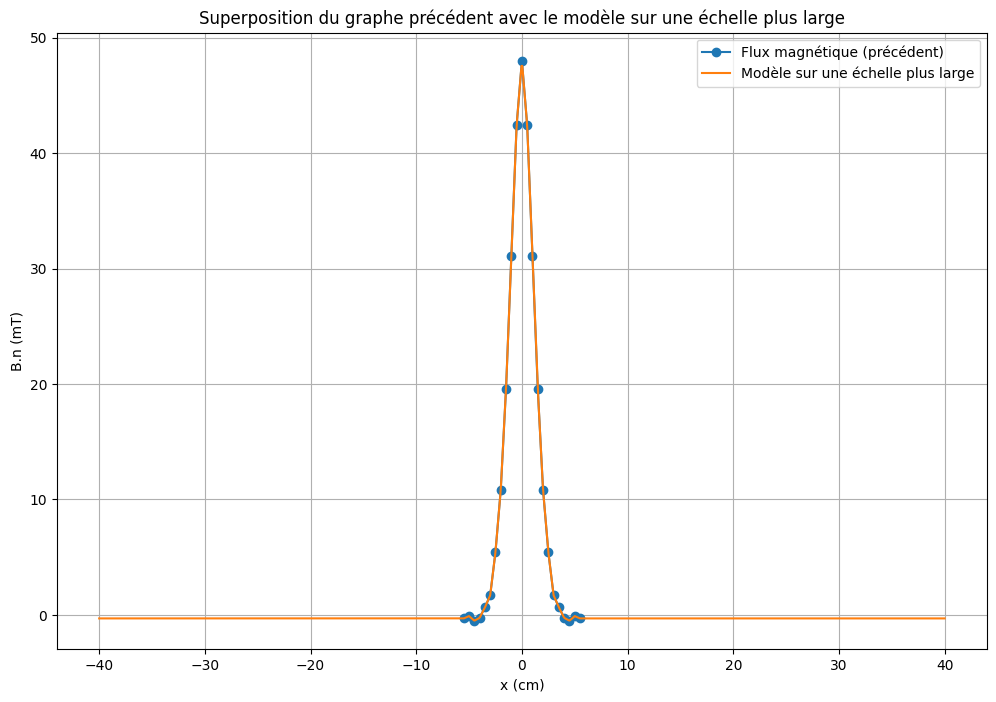

In [14]:
# Étendre la plage de x pour une échelle plus large
x_large = np.linspace(-40, 40, 1000)

# Calculer les valeurs du champ magnétique pour le modèle sur cette plage
field_values_large = [get_field_at_distance(x*1e-2, dist_trunc*1e-2, vals_trunc) for x in x_large]

# Superposer le graphe précédent avec le modèle
plt.figure(figsize=(12, 8))
plt.plot(dist_trunc, vals_trunc, label='Flux magnétique (précédent)', linestyle='-', marker='o')
plt.plot(x_large, field_values_large, label='Modèle sur une échelle plus large')
plt.xlabel('x (cm)')
plt.ylabel('B.n (mT)')
plt.title('Superposition du graphe précédent avec le modèle sur une échelle plus large')
plt.legend()
plt.grid(True)
plt.show()

### Approximation dans la simulation:

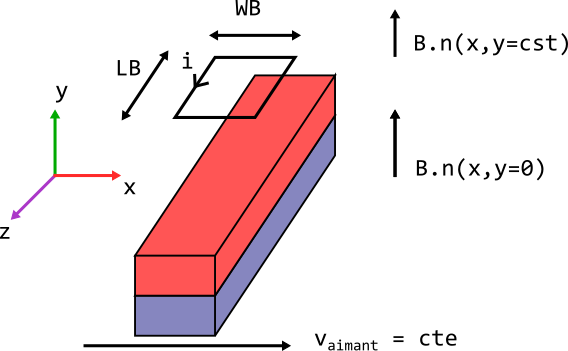

on suppose la bobine a une hauteur $y$ de l'aimant qui passe en dessous a une vitesse $v_{aimant}$, l'aimant est supposé infini selon l'axe z pour simplifier les calculs (raisonnable si LB \< longueur de l'aimant)

on integre alors le flux a travers la bobine sur x: $\Phi(X) = \int_{-X-WB/2}^{-X+WB/2} B.n(y=cste, x) \space LB \space dx$ car un deplacement de l'aimant de X revient a un deplacement de -X relatif de la bobine // a l'aimant et donc son champ.

In [39]:
#dimensionnement de la bobine
#2x2cm selon les axes respectifs z et x
BW=2e-2
BL=2e-2

def get_flux(mag_funct, offsetx, deltax=1e-3):#1mm dej bien, 0.1 un peu extreme
    # deltax est la taille de la cellule
    # mag_funct est une fonction qui prend en entrée la distance et renvoie la valeur du champ magnétique
    # on suppose B constant // à z, fonction de x
    # on intègre sur x et z
    flux = 0
    x_values = np.arange(-BW/2-offsetx, BW/2 - offsetx + deltax, deltax) #valeurs de x sur lesquelles on integre
    for x in x_values:
        # On suppose que la fonction mag_funct est définie pour renvoyer le champ magnétique à une distance donnée
        B = mag_funct(x)  # On suppose que mag_funct est une fonction de x
        flux += B * deltax * BL  # Contribution de chaque cellule
        
    return flux

N_magnets = 21 # Nombre total d'aimants
group_mag = 7 #skip every 7th magnet
mag_offset = 9e-2 #5cm max pour que le modele soit valide
mag_positions = []
def field_func(x):
    #somme les contributions de chaque aimant
    total_field = 0
    for i in range(N_magnets):
        # Position de l'aimant i
        if i % group_mag == 0:
            continue
        j=i-i//group_mag  # Skip every 7th magnet

        magnet_position = -i * mag_offset
        mag_positions.append(magnet_position)

        # Contribution de l'aimant i
        total_field += ((-1)**j)*get_field_at_distance(x - magnet_position, dist_trunc*1e-2, vals_trunc)
    return total_field

# Simulation de l'effet du mouvement de l'aimant
# Parametres de la simulation ! attention parametres et ocnfig des aimants au dessus
RAYON_ROUE = 0.69/2 #m
RAYON_AIMANT = 95e-3 #mm soit 9.5cm
vitesse_velo = 15 #kmph
vitesse_velo = vitesse_velo * 1000 / 3600  # Convertir en m/s
omega = vitesse_velo / RAYON_ROUE  # Vitesse angulaire en rad/s
v = omega * RAYON_AIMANT  # Vitesse linéaire de l'aimant en m/s
# Initialisation de la simulation
Tmax = 5  # 5 secondes de sim
N=5000 #nb de pas de temps
T = np.linspace(0, Tmax, N)  # Valeurs de deltax à tester
dt = Tmax/(N-1)
print(f"simulation pour v_aimant = {v:.2e} m/s, omega = {omega:.2f} rad/s, soit une vitesse au sol de {vitesse_velo:.2f} m/s")
# v = 0.5  # Vitesse de déplacement en m/s
startx = -0.5 #position initiale, arrivée du 1er aimant apres 1seconde
x = startx  # Position initiale
flux_values = []
for t in tqdm(T):
    flux = get_flux(field_func, x)
    flux_values.append(flux)
    deltax = v * dt
    x += deltax  # Mise à jour de la position

simulation pour v_aimant = 1.15e+00 m/s, omega = 12.08 rad/s, soit une vitesse au sol de 4.17 m/s


100%|██████████| 5000/5000 [00:09<00:00, 536.58it/s]


On vérifie la validité du champ (j'avais un bug lié a la valeur de deltax (0.5m qui était bien trop grand, réduit à 1mm))

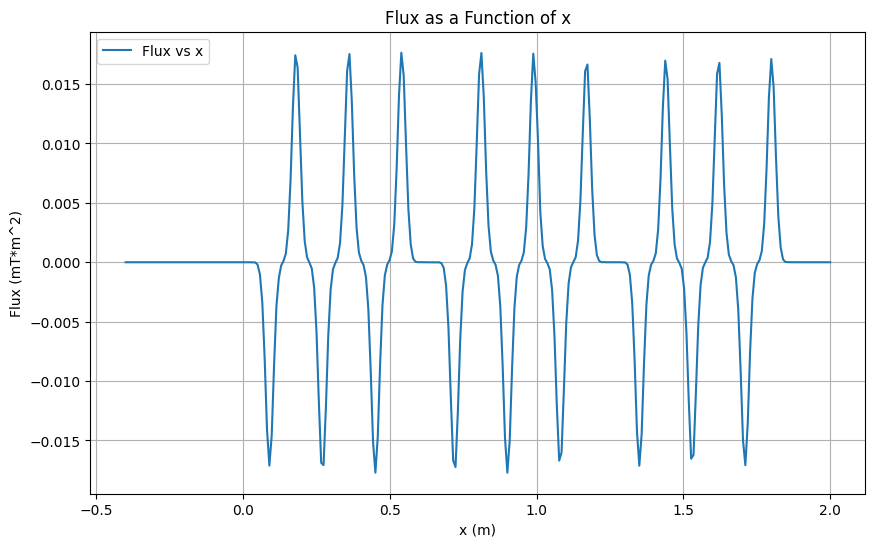

In [40]:
# Define a range of x values
x_range = np.linspace(-0.4, 2, 300)  # Adjust the range and number of points as needed

# Compute the flux for each x value
flux_for_x = [get_flux(field_func, x) for x in x_range]

# Plot the flux as a function of x
plt.figure(figsize=(10, 6))
plt.plot(x_range, flux_for_x, label='Flux vs x', linestyle='-', marker='')
plt.xlabel('x (m)')
plt.ylabel('Flux (mT*m^2)')
plt.title('Flux as a Function of x')
plt.legend()
plt.grid(True)
plt.show()

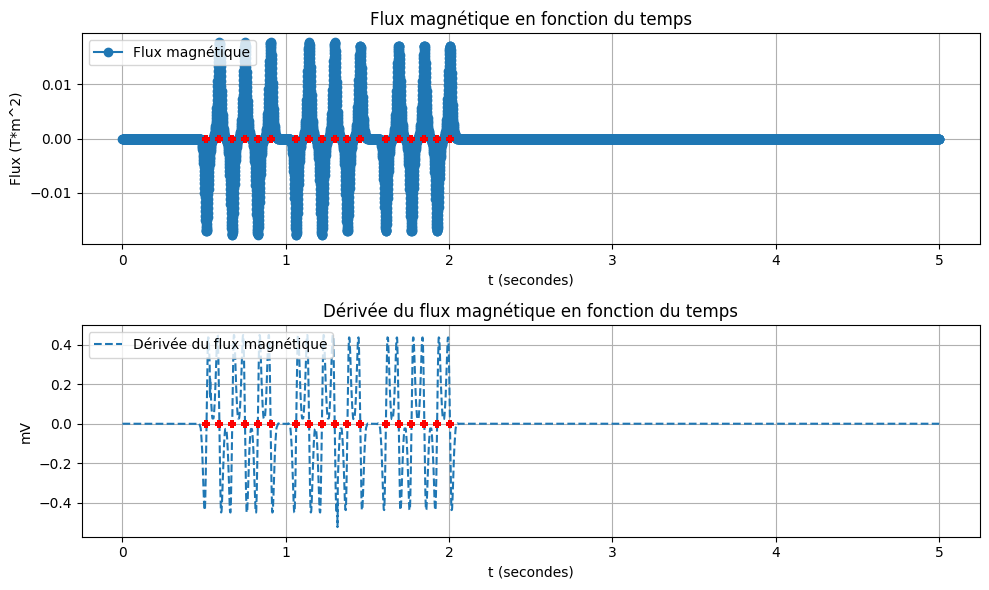

In [ ]:
#plot flux en fonction de t
magnet_times = (-np.array(mag_positions)-startx)/v
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(T, flux_values, marker='o', linestyle='-', label='Flux magnétique')
plt.scatter(magnet_times, [0]*len(magnet_times), color="red", marker="+",zorder=10)
plt.xlabel('t (secondes)')
plt.ylabel('Flux (T*m^2)')
plt.title('Flux magnétique en fonction du temps')
plt.legend(loc="upper left")
plt.grid(True)
#derivation
plt.subplot(2, 1, 2)
flux_derivative = np.gradient(flux_values, dt)*1e-3
plt.plot(T, flux_derivative, marker='', linestyle='--', label='Dérivée du flux magnétique')
plt.scatter(magnet_times, [0]*len(magnet_times), color="red", marker="+",zorder=10)
#plot the magnet arrival times
plt.xlabel('t (secondes)')
plt.ylabel('mV')
plt.title('Dérivée du flux magnétique en fonction du temps')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

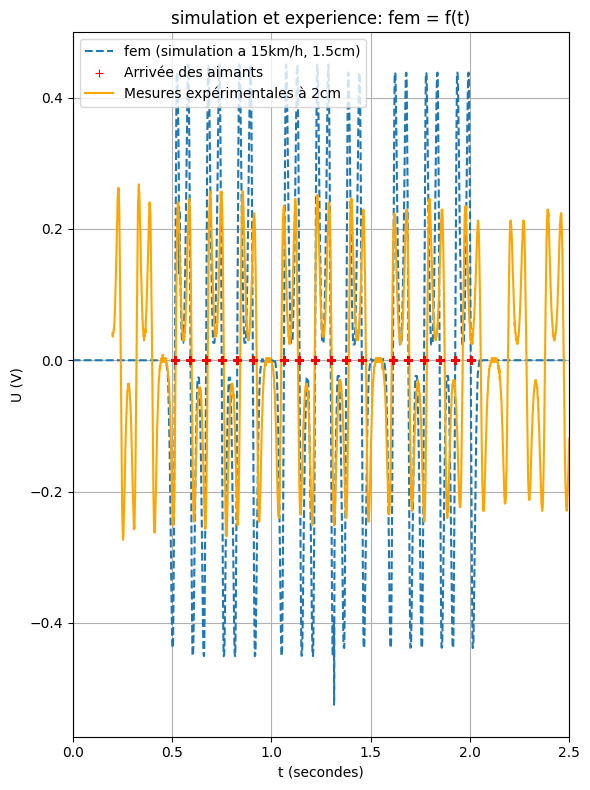

In [58]:
# Load the measurement data from the CSV file
measurement_data = np.loadtxt('../data/mesure2cm_bis_3.csv', delimiter=',', skiprows=1)
N_tours = 350 # Nombre de tours de bobine
# Extract time and voltage values
time_measurement = measurement_data[:, 0]
voltage_measurement = measurement_data[:, 1]
fem_calc = flux_derivative * N_tours

# Plot the derivative and superimpose the measurement data
plt.figure(figsize=(6, 8))
plt.plot(T, flux_derivative, marker='', linestyle='--', label='fem (simulation a 15km/h, 1.5cm)')
plt.scatter(magnet_times, [0]*len(magnet_times), color="red", marker="+", zorder=10, label='Arrivée des aimants', linewidths=0.8)
plt.plot(time_measurement+0.20, voltage_measurement, marker='', linestyle='-', label='Mesures expérimentales à 2cm', color='orange')
plt.xlim(0,2.5)
plt.xlabel('t (secondes)')
plt.ylabel('U (V)')
plt.title('simulation et experience: fem = f(t)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()